In [1]:
from pathlib import Path
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor, AutoModelForCausalLM, AutoTokenizer
from qwen_vl_utils import process_vision_info
from time import perf_counter
import sys
sys.path.extend([str(Path.home() / 'PycharmProjects/item_matching')])

from func import Draw

In [2]:
file = Path.home() / 'Downloads/Data/1F7B6D90-0B3B-46C7-9988-E230E0D06163_1_105_c.jpeg'

In [3]:
flash_attention_2 = False
model_id = 'Qwen/Qwen2-VL-2B-Instruct'
config = {
    'pretrained_model_name_or_path': model_id,
    'torch_dtype': 'auto',
    'device_map': 'auto',
    'attn_implementation': None,
}
if flash_attention_2:
    config.update({
        'torch_dtype': torch.bfloat16,
        'attn_implementation': 'flash_attention_2'
    })
model = Qwen2VLForConditionalGeneration.from_pretrained(**config)
processor = AutoProcessor.from_pretrained(
    model_id,
    min_pixels=64 * 28 * 28,
    max_pixels=512 * 28 * 28,
)

Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section'}
`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
start = perf_counter()
prompt = f"""

Given an ultra trail race map and its corresponding elevation profile, analyze the following:

Overall Elevation Gain and Loss: Determine the total elevation gain and loss throughout the race.
Key Elevation Points: Identify the highest and lowest points along the course, as well as any significant passes or summits.
Elevation Grade: Analyze the average and maximum elevation grades, particularly on climbs and descents.
Elevation Profile Analysis: Describe the general shape of the elevation profile and identify any notable features, such as long climbs, steep descents, or rolling terrain.
Impact on Race Strategy: Discuss how the elevation profile might influence race strategy, including pacing, nutrition, and hydration planning.
Additional Questions to Consider:

Are there any technical sections with significant elevation changes, such as rock scrambles or scree fields?
How does the elevation profile compare to other ultra trail races in the region?
Are there any sections of the course that may be particularly challenging due to elevation-related factors?
Tips for Analyzing the Map and Elevation Profile:

Use a mapping tool or software to measure distances, elevations, and grades.
Consider the scale of the map and the accuracy of the elevation data.
Look for visual cues on the map, such as contour lines, to understand the terrain.
Relate the elevation profile to the overall race distance and expected pace.
By carefully analyzing these aspects, you can gain a better understanding of the challenges and opportunities presented by the ultra trail race course.

"""
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": str(file),
            },
            {"type": "text", "text": prompt},
        ],
    }
]

text = processor.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
    add_vision_id=False
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors='pt',
)
inputs = inputs.to(model.device)

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=256)
generated_ids_trimmed = [
    out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed,
    skip_special_tokens=True,
    clean_up_tokenization_spaces=False
)
print(f'[Visual Summarization] Time: {perf_counter() - start:,.0f}s')

[Visual Summarization] Time: 34s


In [5]:
print(output_text[0])

The ultra trail race map and its corresponding elevation profile provide valuable insights into the course's elevation changes and potential challenges. Here's a detailed analysis:

### Overall Elevation Gain and Loss
The total elevation gain and loss throughout the race are as follows:

- **Elevation Gain**: 1918 meters
- **Elevation Loss**: 1918 meters

### Key Elevation Points
- **Highest Point**: 14,34 meters (CP10)
- **Lowest Point**: 11,5 meters (CP9)
- **Significant Passes**: CP9, CP10, and CP11 (all 1,100 meters)
- **Summits**: CP9 and CP10 (both 1,434 meters)

### Elevation Grade Analysis
- **Average Elevation Grade**: Approximately 15%
- **Maximum Elevation Grade**: 16%

### Elevation Profile Analysis
The elevation profile shows a general increase in elevation from the start (11,5 meters) to the finish (14,34 meters). The course features several significant passes and summits, including CP9 and CP10, which are notable for their elevation gains.

###


/Users/kevinkhang/PycharmProjects/item_matching/notebooks/examples/func.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


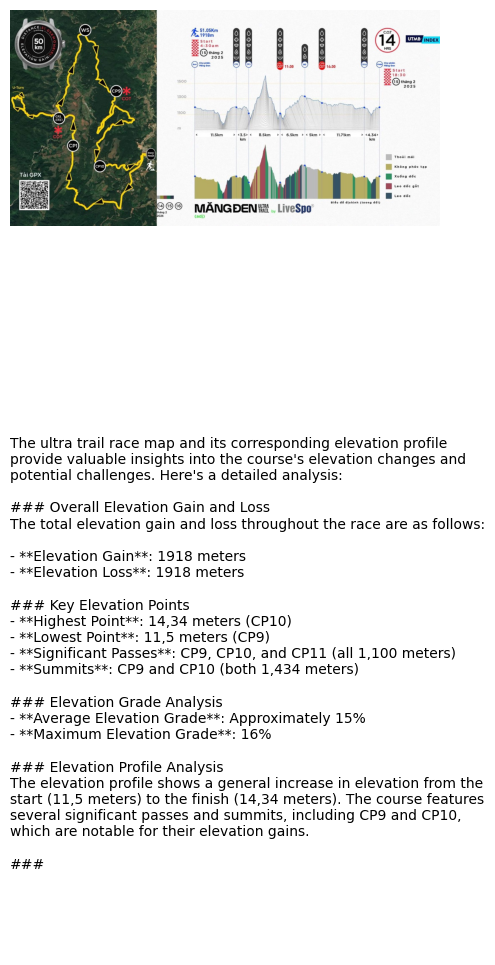

In [6]:
Draw().plot_one_image_long_caption(file, output_text[0], vertical=True)

/var/folders/26/dznmhxzs0mj48gq4lgw3g6bm0000gn/T/ipykernel_43998/3855776010.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


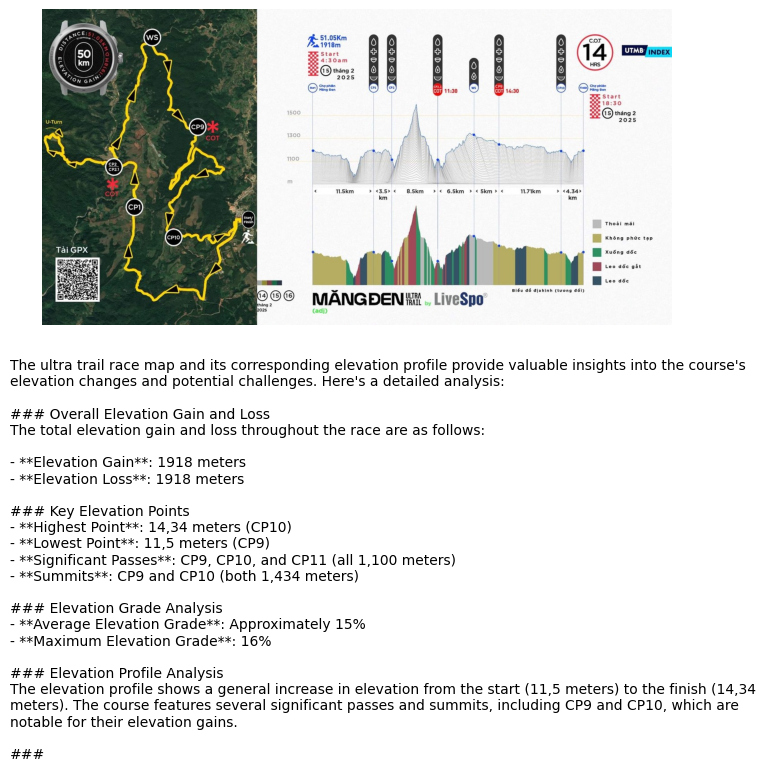

In [14]:
import matplotlib.pyplot as plt
from PIL import Image
nrows, ncols = 2, 1
fig_size = (8, 8)

fig, (ax1, ax2) = plt.subplots(nrows, ncols, figsize=fig_size)
ax1.imshow(Image.open(file))
ax1.axis('off')
ax2.text(0, 0.5, output_text[0], va='center', ha='left', wrap=True)
ax2.axis('off')
fig.tight_layout()
fig.show()